In [1]:
# Step 1: Install necessary libraries
!pip install contractions
!pip install gensim


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Step 2: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import contractions
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import gensim.downloader as api
from wordcloud import WordCloud

In [3]:
# Step 3: Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\londonreturns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\londonreturns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\londonreturns\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\londonreturns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import pandas as pd
df = pd.read_csv('6. News Category Dataset/news_category.csv')

In [6]:
# Step 5: Display basic dataset information
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nCategory distribution:")
print(df['category'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11025 entries, 0 to 11024
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  11025 non-null  object
 1   category  11025 non-null  object
dtypes: object(2)
memory usage: 172.4+ KB
None

First 5 rows:
                                            headline        category
0  How A New Documentary Captures The Complexity ...  CULTURE & ARTS
1  Twitch Bans Gambling Sites After Streamer Scam...            TECH
2  'Reboot' Is A Clever And Not Too Navel-Gazey L...  CULTURE & ARTS
3  Maury Wills, Base-Stealing Shortstop For Dodge...          SPORTS
4  Las Vegas Aces Win First WNBA Title, Chelsea G...          SPORTS

Category distribution:
category
SPORTS            5077
TECH              2104
MONEY             1756
CULTURE & ARTS    1074
EDUCATION         1014
Name: count, dtype: int64


In [7]:
# Step 6: Text Preprocessing
# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Clean text
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.strip()

    # Expand contractions
    text = contractions.fix(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and short words (length < 2)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply preprocessing to the 'headline' column
print("\nPreprocessing headlines...")
df['preprocessed_headline'] = df['headline'].apply(preprocess_text)


Preprocessing headlines...


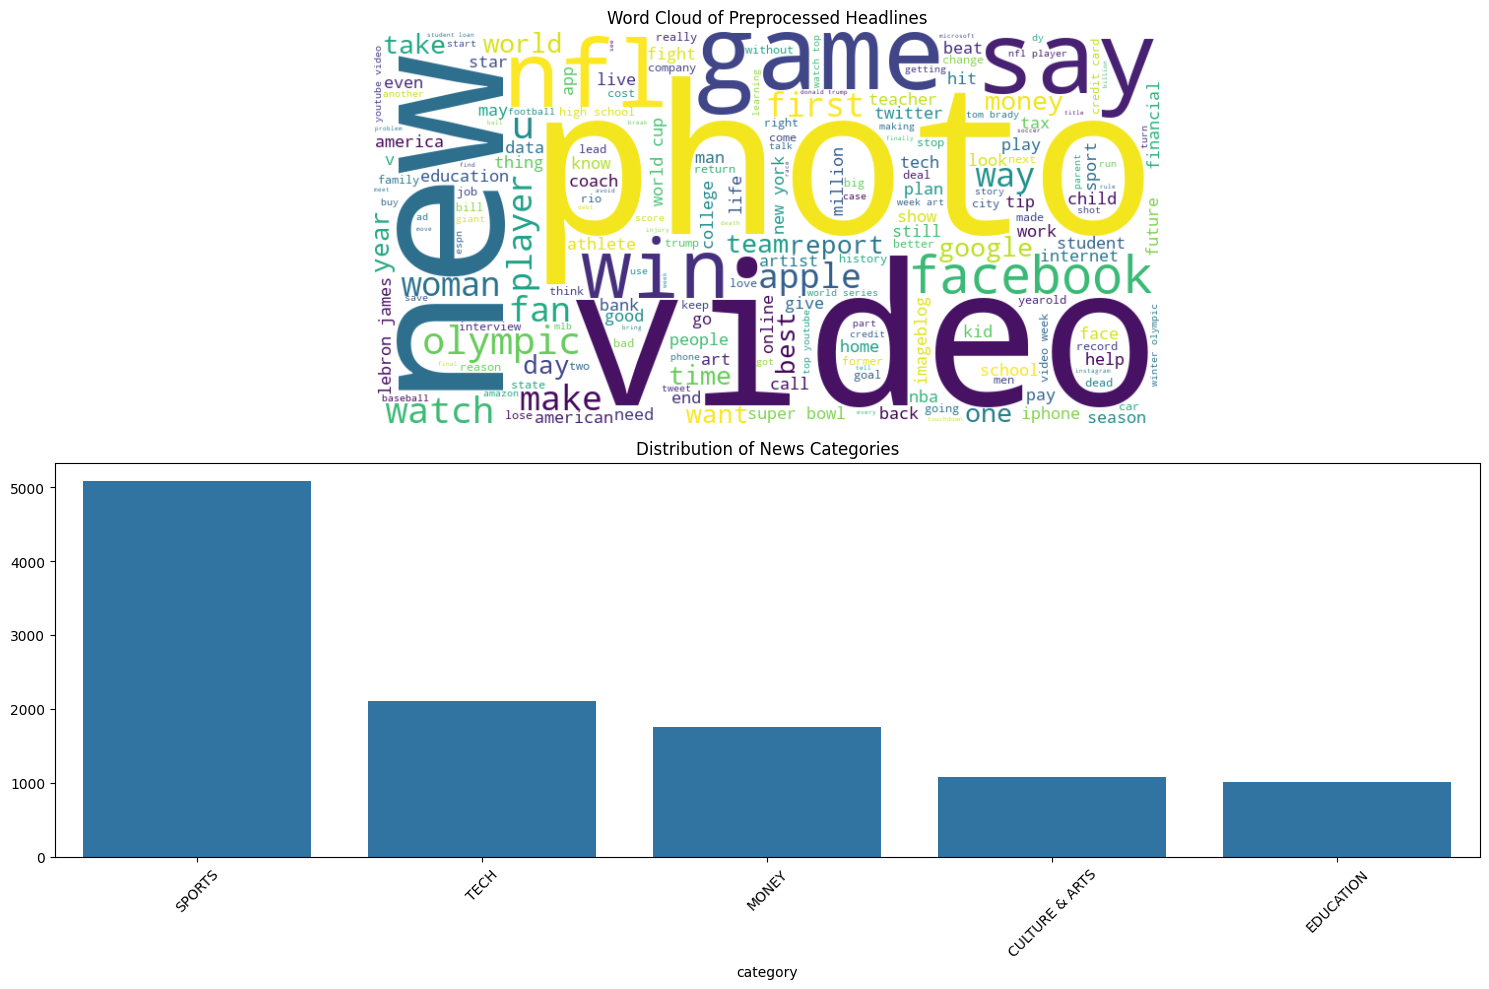

In [8]:
# Step 7: Visualize cleaned data
plt.figure(figsize=(15, 10))

# Word Cloud
plt.subplot(2, 1, 1)
all_text = ' '.join(df['preprocessed_headline'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Headlines')

# Category distribution
plt.subplot(2, 1, 2)
category_counts = df['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribution of News Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('data_visualization.png')
plt.show()

In [9]:
# Step 8: Split the data into training and testing sets
X = df['preprocessed_headline']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")



Training samples: 8820
Testing samples: 2205


In [10]:
# Step 9: Tokenize and pad sequences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine maximum sequence length (95th percentile)
lengths = [len(seq) for seq in X_train_seq]
max_length = int(np.percentile(lengths, 95))
print(f"\nMaximum sequence length (95th percentile): {max_length}")

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')



Maximum sequence length (95th percentile): 11


In [11]:
# Step 10: Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

# One-hot encode labels
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

print("\nLabel classes:", le.classes_)


Label classes: ['CULTURE & ARTS' 'EDUCATION' 'MONEY' 'SPORTS' 'TECH']


In [12]:
# Step 11: Build and train models
vocab_size = len(tokenizer.word_index) + 1
print(f"\nVocabulary size: {vocab_size}")

def build_and_train_model(model_type, embedding_type='trainable', embedding_dim=100, epochs=50):
    model = Sequential()

    if embedding_type == 'trainable':
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    elif embedding_type == 'word2vec':
        # Load pre-trained Word2Vec model
        print("Loading Word2Vec model...")
        word2vec_model = api.load('word2vec-google-news-300')

        # Create embedding matrix
        embedding_dim = 300  # Google News Word2Vec is 300-dimensional
        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        for word, i in tokenizer.word_index.items():
            if i < vocab_size:
                try:
                    embedding_vector = word2vec_model[word]
                    embedding_matrix[i] = embedding_vector
                except KeyError:
                    pass  # Word not in vocabulary

        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                          input_length=max_length, weights=[embedding_matrix], trainable=False))

    if model_type == 'rnn':
        model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2))
    elif model_type == 'lstm':
        model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print(f"\nTraining {model_type.upper()} model with {embedding_type} embeddings...")
    history = model.fit(
        X_train_padded, y_train_cat,
        epochs=epochs,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    return model, history

# Model 1: Simple RNN with trainable embedding
model1, history1 = build_and_train_model('rnn', 'trainable')


Vocabulary size: 11998

Training RNN model with trainable embeddings...
Epoch 1/50


c:\Users\londonreturns\Downloads\temp\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3777 - loss: 1.5036 - val_accuracy: 0.5062 - val_loss: 1.2850
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5289 - loss: 1.1951 - val_accuracy: 0.6077 - val_loss: 0.9672
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6289 - loss: 0.9022 - val_accuracy: 0.6689 - val_loss: 0.8753
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6979 - loss: 0.7444 - val_accuracy: 0.6848 - val_loss: 0.9230
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7523 - loss: 0.6111 - val_accuracy: 0.6899 - val_loss: 0.9966
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8007 - loss: 0.5142 - val_accuracy: 0.6763 - val_loss: 1.0227
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8210 - loss: 0.4560 - val_accuracy: 0.6939 - val_loss: 1.1614
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8689 - loss: 0.3685 - val_accuracy: 0.7154 - val_

In [13]:
# Model 2: LSTM with trainable embedding
model2, history2 = build_and_train_model('lstm', 'trainable')

# Model 3: LSTM with pre-trained Word2Vec embeddings
try:
    model3, history3 = build_and_train_model('lstm', 'word2vec')
except Exception as e:
    print(f"\nError loading Word2Vec model: {e}")
    model3 = None

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    if model is None:
        return

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\nEvaluation for {model_name}:")
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

    print("Confusion Matrix:")
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_enc, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.show()

    accuracy = accuracy_score(y_test_enc, y_pred_classes)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy



Training LSTM model with trainable embeddings...
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4091 - loss: 1.4737 - val_accuracy: 0.6083 - val_loss: 0.9540
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6261 - loss: 0.8897 - val_accuracy: 0.7466 - val_loss: 0.7033
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7901 - loss: 0.5472 - val_accuracy: 0.7993 - val_loss: 0.6234
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9006 - loss: 0.3090 - val_accuracy: 0.7914 - val_loss: 0.7105
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9510 - loss: 0.1766 - val_accuracy: 0.8260 - val_loss: 0.7511
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9695 - loss: 0.1347 - val_accuracy: 0.8180 - val_loss: 0.8145
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9810 - loss: 0.0864 - val_accuracy: 0.8135 - val_loss: 0.9607
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/s

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluation for Simple RNN:
Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.31      0.02      0.04       215
     EDUCATION       0.29      0.57      0.38       203
         MONEY       0.43      0.41      0.42       351
        SPORTS       0.90      0.87      0.88      1015
          TECH       0.60      0.67      0.63       421

      accuracy                           0.65      2205
     macro avg       0.51      0.51      0.47      2205
  weighted avg       0.65      0.65      0.63      2205

Confusion Matrix:


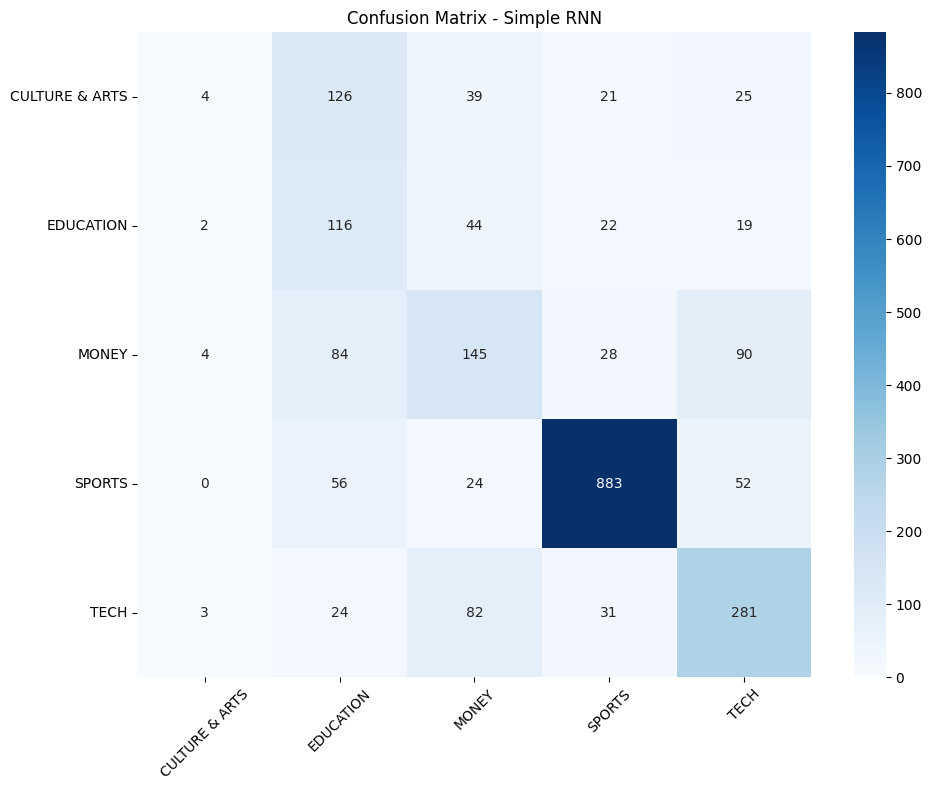

Accuracy: 0.6481
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Evaluation for LSTM:
Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.73      0.60      0.66       215
     EDUCATION       0.73      0.53      0.62       203
         MONEY       0.72      0.72      0.72       351
        SPORTS       0.94      0.90      0.92      1015
          TECH       0.64      0.85      0.73       421

      accuracy                           0.80      2205
     macro avg       0.75      0.72      0.73      2205
  weighted avg       0.81      0.80      0.80      2205

Confusion Matrix:


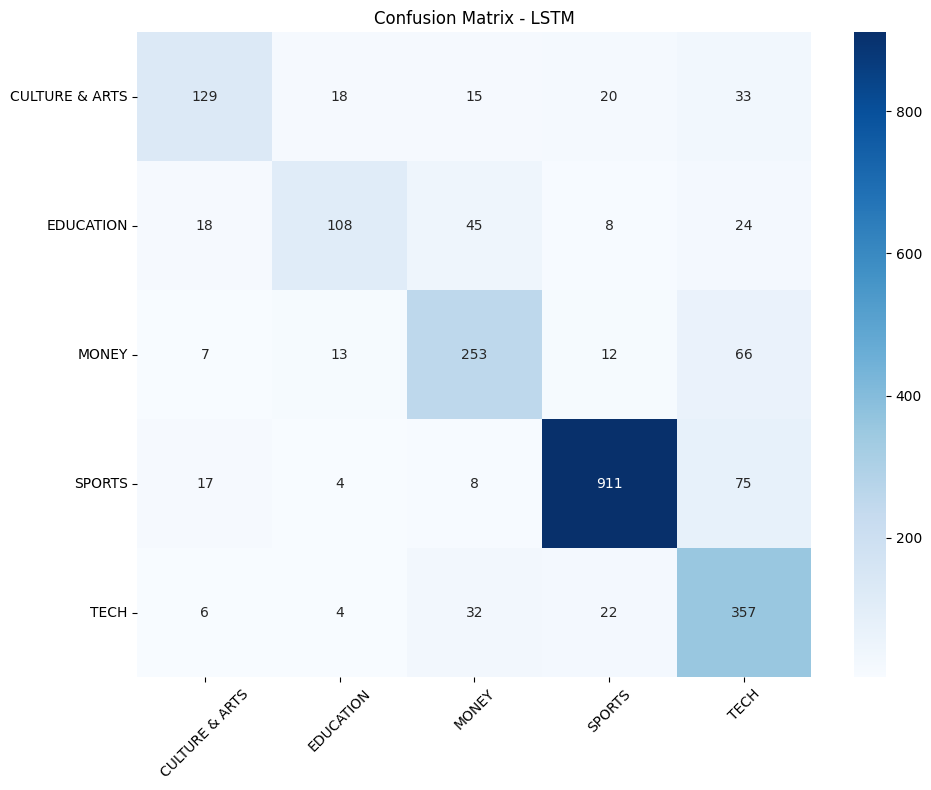

Accuracy: 0.7973
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Evaluation for LSTM with Word2Vec:
Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.72      0.78      0.75       215
     EDUCATION       0.80      0.71      0.75       203
         MONEY       0.83      0.77      0.80       351
        SPORTS       0.90      0.94      0.92      1015
          TECH       0.83      0.81      0.82       421

      accuracy                           0.85      2205
     macro avg       0.82      0.80      0.81      2205
  weighted avg       0.85      0.85      0.85      2205

Confusion Matrix:


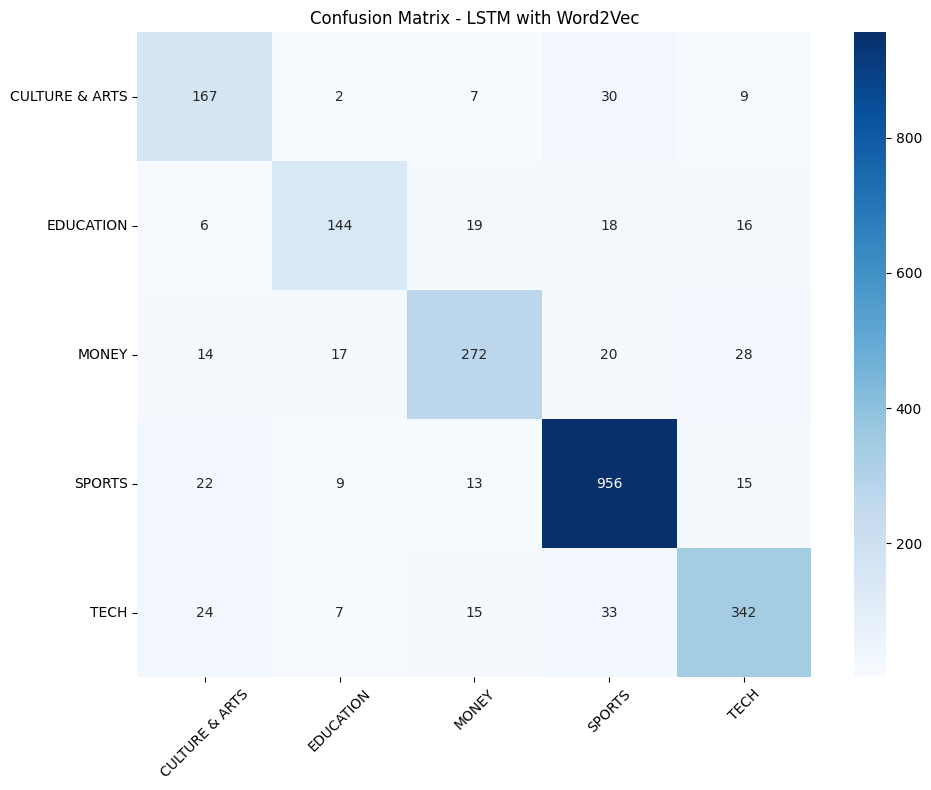

Accuracy: 0.8531


In [14]:
# Evaluate all models
accuracies = {}
accuracies['Simple RNN'] = evaluate_model(model1, X_test_padded, y_test_enc, "Simple RNN")
accuracies['LSTM'] = evaluate_model(model2, X_test_padded, y_test_enc, "LSTM")
if model3 is not None:
    accuracies['LSTM with Word2Vec'] = evaluate_model(model3, X_test_padded, y_test_enc, "LSTM with Word2Vec")



Model Accuracy Comparison:
Simple RNN: 0.6481
LSTM: 0.7973
LSTM with Word2Vec: 0.8531


C:\Users\londonreturns\AppData\Local\Temp\ipykernel_51016\2361783036.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=scores, palette="viridis")


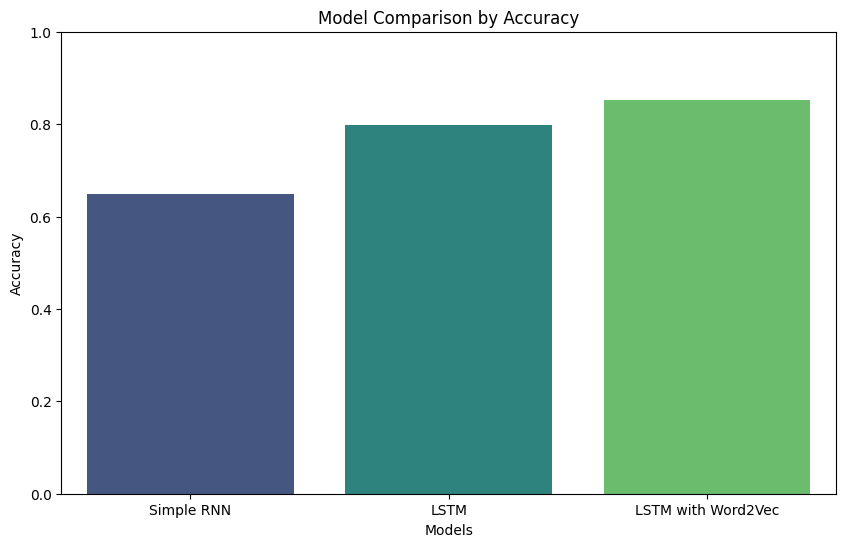


Detailed Evaluation of Models:
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Evaluation for Simple RNN:
Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.31      0.02      0.04       215
     EDUCATION       0.29      0.57      0.38       203
         MONEY       0.43      0.41      0.42       351
        SPORTS       0.90      0.87      0.88      1015
          TECH       0.60      0.67      0.63       421

      accuracy                           0.65      2205
     macro avg       0.51      0.51      0.47      2205
  weighted avg       0.65      0.65      0.63      2205

Confusion Matrix:


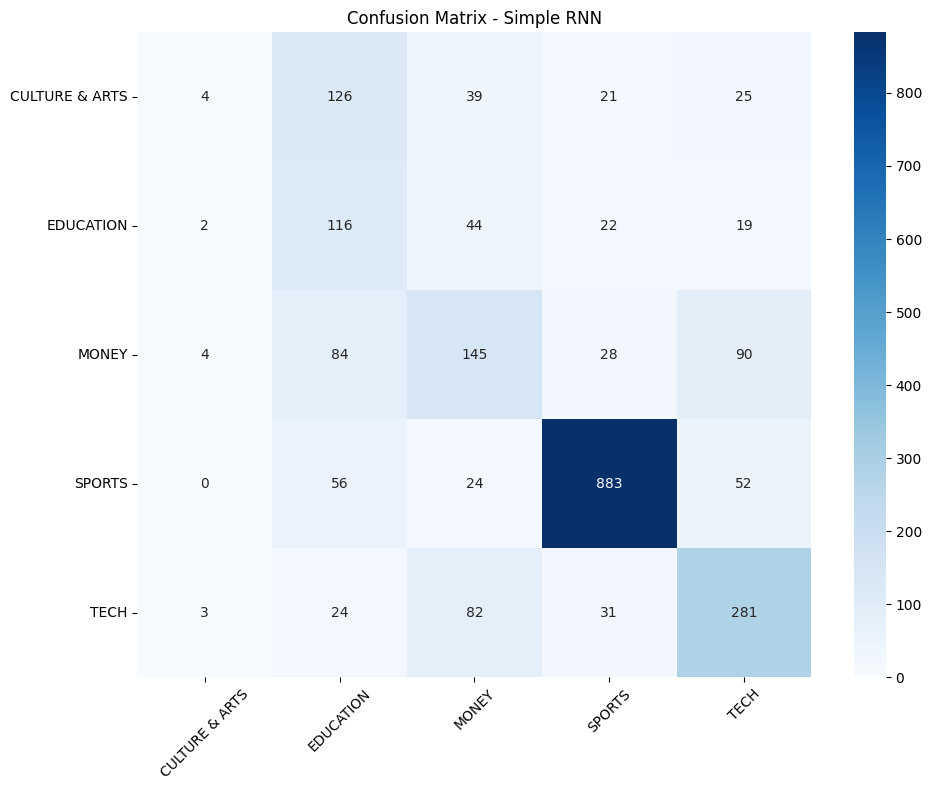

Accuracy: 0.6481
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Evaluation for LSTM:
Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.73      0.60      0.66       215
     EDUCATION       0.73      0.53      0.62       203
         MONEY       0.72      0.72      0.72       351
        SPORTS       0.94      0.90      0.92      1015
          TECH       0.64      0.85      0.73       421

      accuracy                           0.80      2205
     macro avg       0.75      0.72      0.73      2205
  weighted avg       0.81      0.80      0.80      2205

Confusion Matrix:


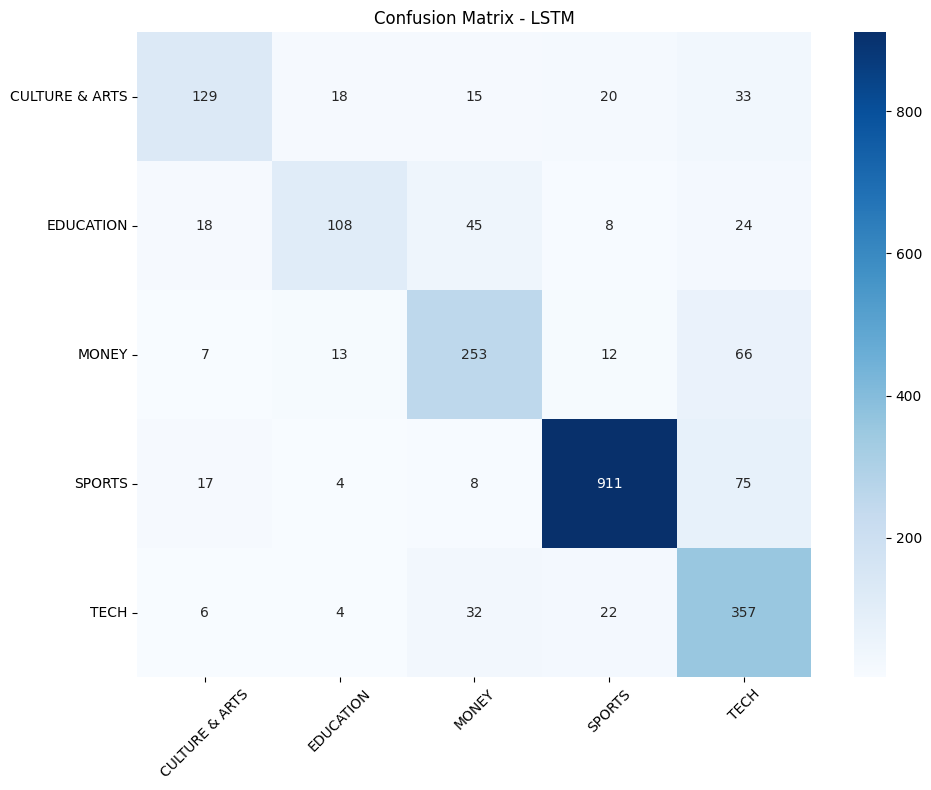

Accuracy: 0.7973
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Evaluation for LSTM with Word2Vec:
Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.72      0.78      0.75       215
     EDUCATION       0.80      0.71      0.75       203
         MONEY       0.83      0.77      0.80       351
        SPORTS       0.90      0.94      0.92      1015
          TECH       0.83      0.81      0.82       421

      accuracy                           0.85      2205
     macro avg       0.82      0.80      0.81      2205
  weighted avg       0.85      0.85      0.85      2205

Confusion Matrix:


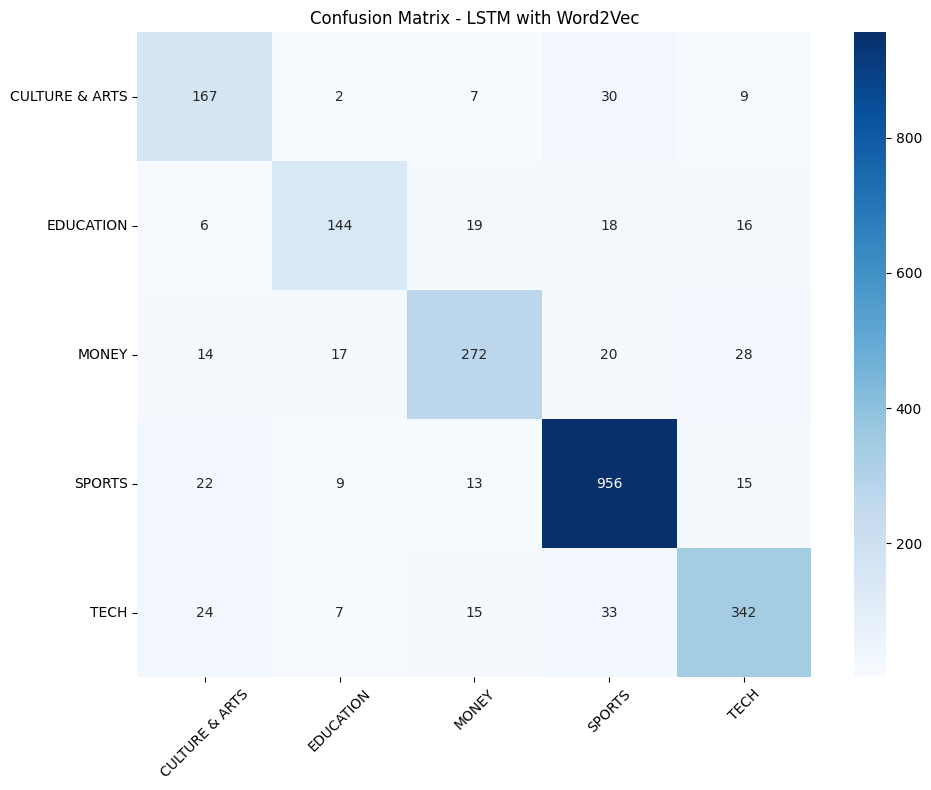

Accuracy: 0.8531


In [15]:
# Step 12: Compare model performances in detail
if accuracies:
    # Display accuracies in a tabular format
    print("\nModel Accuracy Comparison:")
    for model_name, accuracy in accuracies.items():
        print(f"{model_name}: {accuracy:.4f}")

    # Plot accuracies for visual comparison
    plt.figure(figsize=(10, 6))
    models = list(accuracies.keys())
    scores = list(accuracies.values())
    sns.barplot(x=models, y=scores, palette="viridis")
    plt.title('Model Comparison by Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xlabel('Models')
    plt.savefig('model_comparison_detailed.png')
    plt.show()

# Plot training history for each model
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_history_{title.lower().replace(" ", "_")}.png')
    plt.show()

# Evaluate and display confusion matrices and classification reports for all models
print("\nDetailed Evaluation of Models:")
evaluate_model(model1, X_test_padded, y_test_enc, "Simple RNN")
evaluate_model(model2, X_test_padded, y_test_enc, "LSTM")
if model3 is not None:
    evaluate_model(model3, X_test_padded, y_test_enc, "LSTM with Word2Vec")


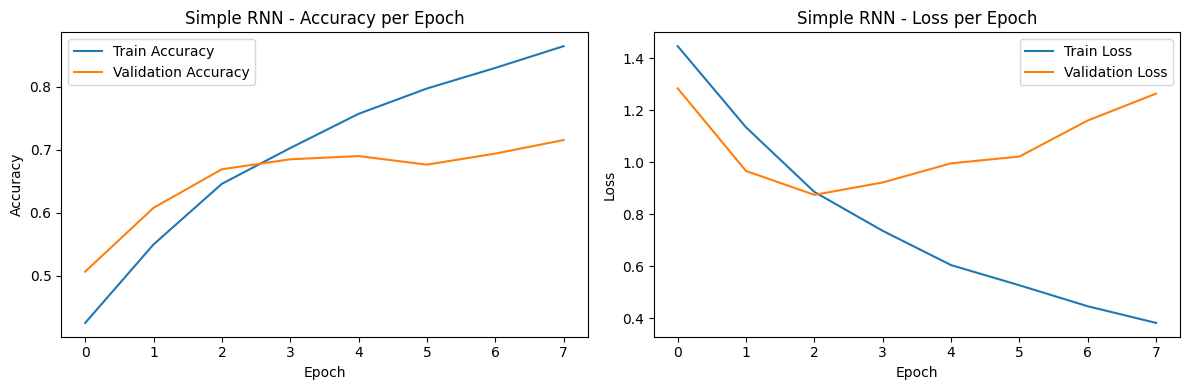

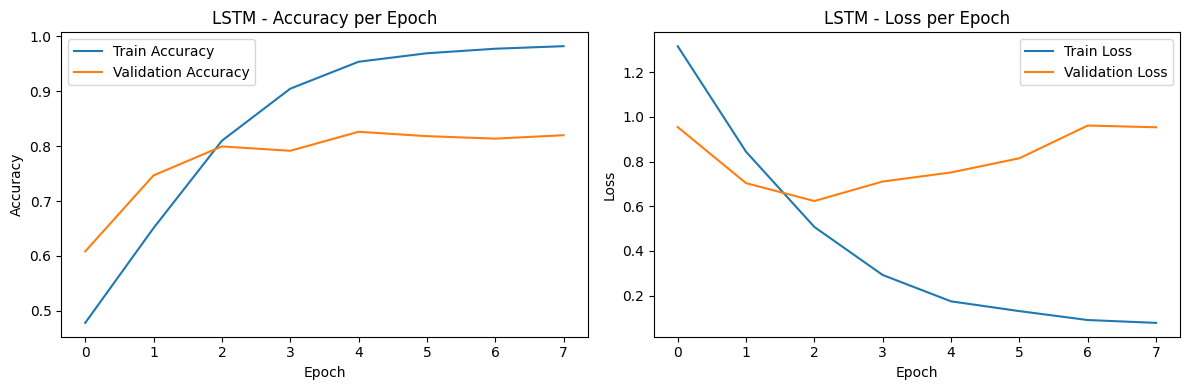

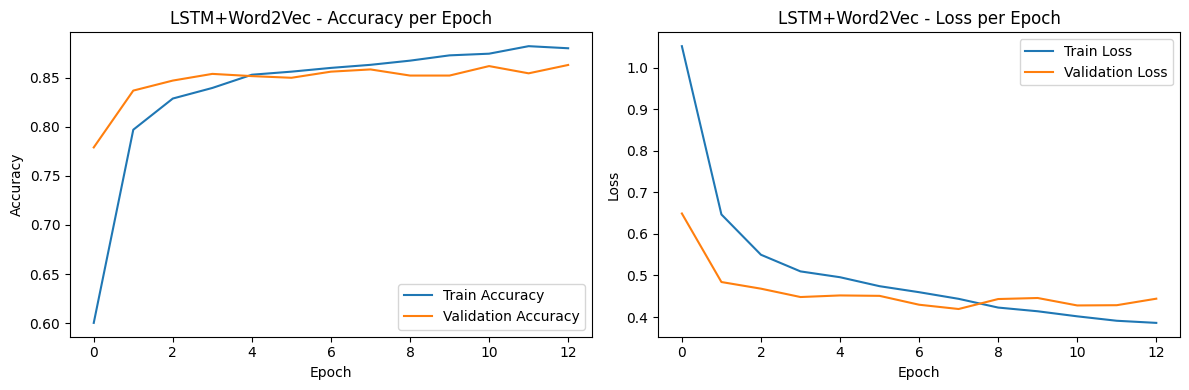

In [18]:
# Plot training/validation loss and accuracy for each model separately

def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_history_{title.lower().replace(" ", "_")}.png')
    plt.show()

# Plot for Simple RNN
plot_history(history1, "Simple RNN")

# Plot for LSTM
plot_history(history2, "LSTM")

# Plot for LSTM+Word2Vec if available
if 'history3' in locals() and history3 is not None:
    plot_history(history3, "LSTM+Word2Vec")

In [16]:
# Step 13: GUI for Real-Time Prediction
!pip install gradio

import gradio as gr

# Select the best model (LSTM with trainable embeddings in this case)
best_model = model2

def predict_category(headline):
    # Preprocess the input
    preprocessed_text = preprocess_text(headline)

    # Convert to sequence and pad
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Make prediction
    prediction = best_model.predict(padded_sequence)[0]
    predicted_class_idx = np.argmax(prediction)
    predicted_class = le.classes_[predicted_class_idx]
    confidence = prediction[predicted_class_idx]

    # Get top 3 predictions
    top3_indices = np.argsort(prediction)[-3:][::-1]
    top3_classes = le.classes_[top3_indices]
    top3_confidences = prediction[top3_indices]

    # Create output dictionary
    result = {
        "Predicted Category": predicted_class,
        "Confidence": float(confidence),
        "Top 3 Predictions": {
            class_name: float(conf) for class_name, conf in zip(top3_classes, top3_confidences)
        }
    }

    return result

# Create Gradio interface
iface = gr.Interface(
    fn=predict_category,
    inputs=gr.Textbox(label="Enter a news headline", placeholder="Type your headline here..."),
    outputs=gr.JSON(label="Prediction Results"),
    title="News Category Classifier",
    description="Enter a news headline to predict its category using our LSTM model.",
    examples=[
        ["Stock markets reach all-time high amid economic recovery"],
        ["Scientists discover new species in Amazon rainforest"],
        ["President announces new policy on climate change"],
        ["Local team wins championship after thrilling final"]
    ]
)

# Launch the interface
print("\nLaunching Gradio interface...")
iface.launch(share=True)  # Set share=True to get a public link


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\londonreturns\Downloads\temp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Launching Gradio interface...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://38865c23f076ac0864.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
